## 1. Data Loading and Exploration



Original shape: (5000, 33)
Shape after dropna: (2034, 33)
--------------------------------------------------------------------------------
Recipe_ID                   0
Recipe_Name                 0
Cuisine_Type                0
Ingredients_List            0
Preparation_Steps           0
Cooking_Time_Minutes        0
Difficulty_Level            0
User_ID                     0
User_Preferences         2003
User_Rating                 0
User_Feedback               0
Date_Prepared               0
Season                      0
Occasion                    0
Serving_Size                0
Calories_Per_Serving        0
Allergen_Information     1948
Cost_Per_Serving            0
Popularity_Score            0
Seasonal_Availability       0
Type_Count                  0
Pre_Count                   0
Ing_Count                   0
Top_Type                    0
Top_Pre                     0
Top_Ing                     0
Total_Time                  0
Type_Freq                   0
Pre_Freq             

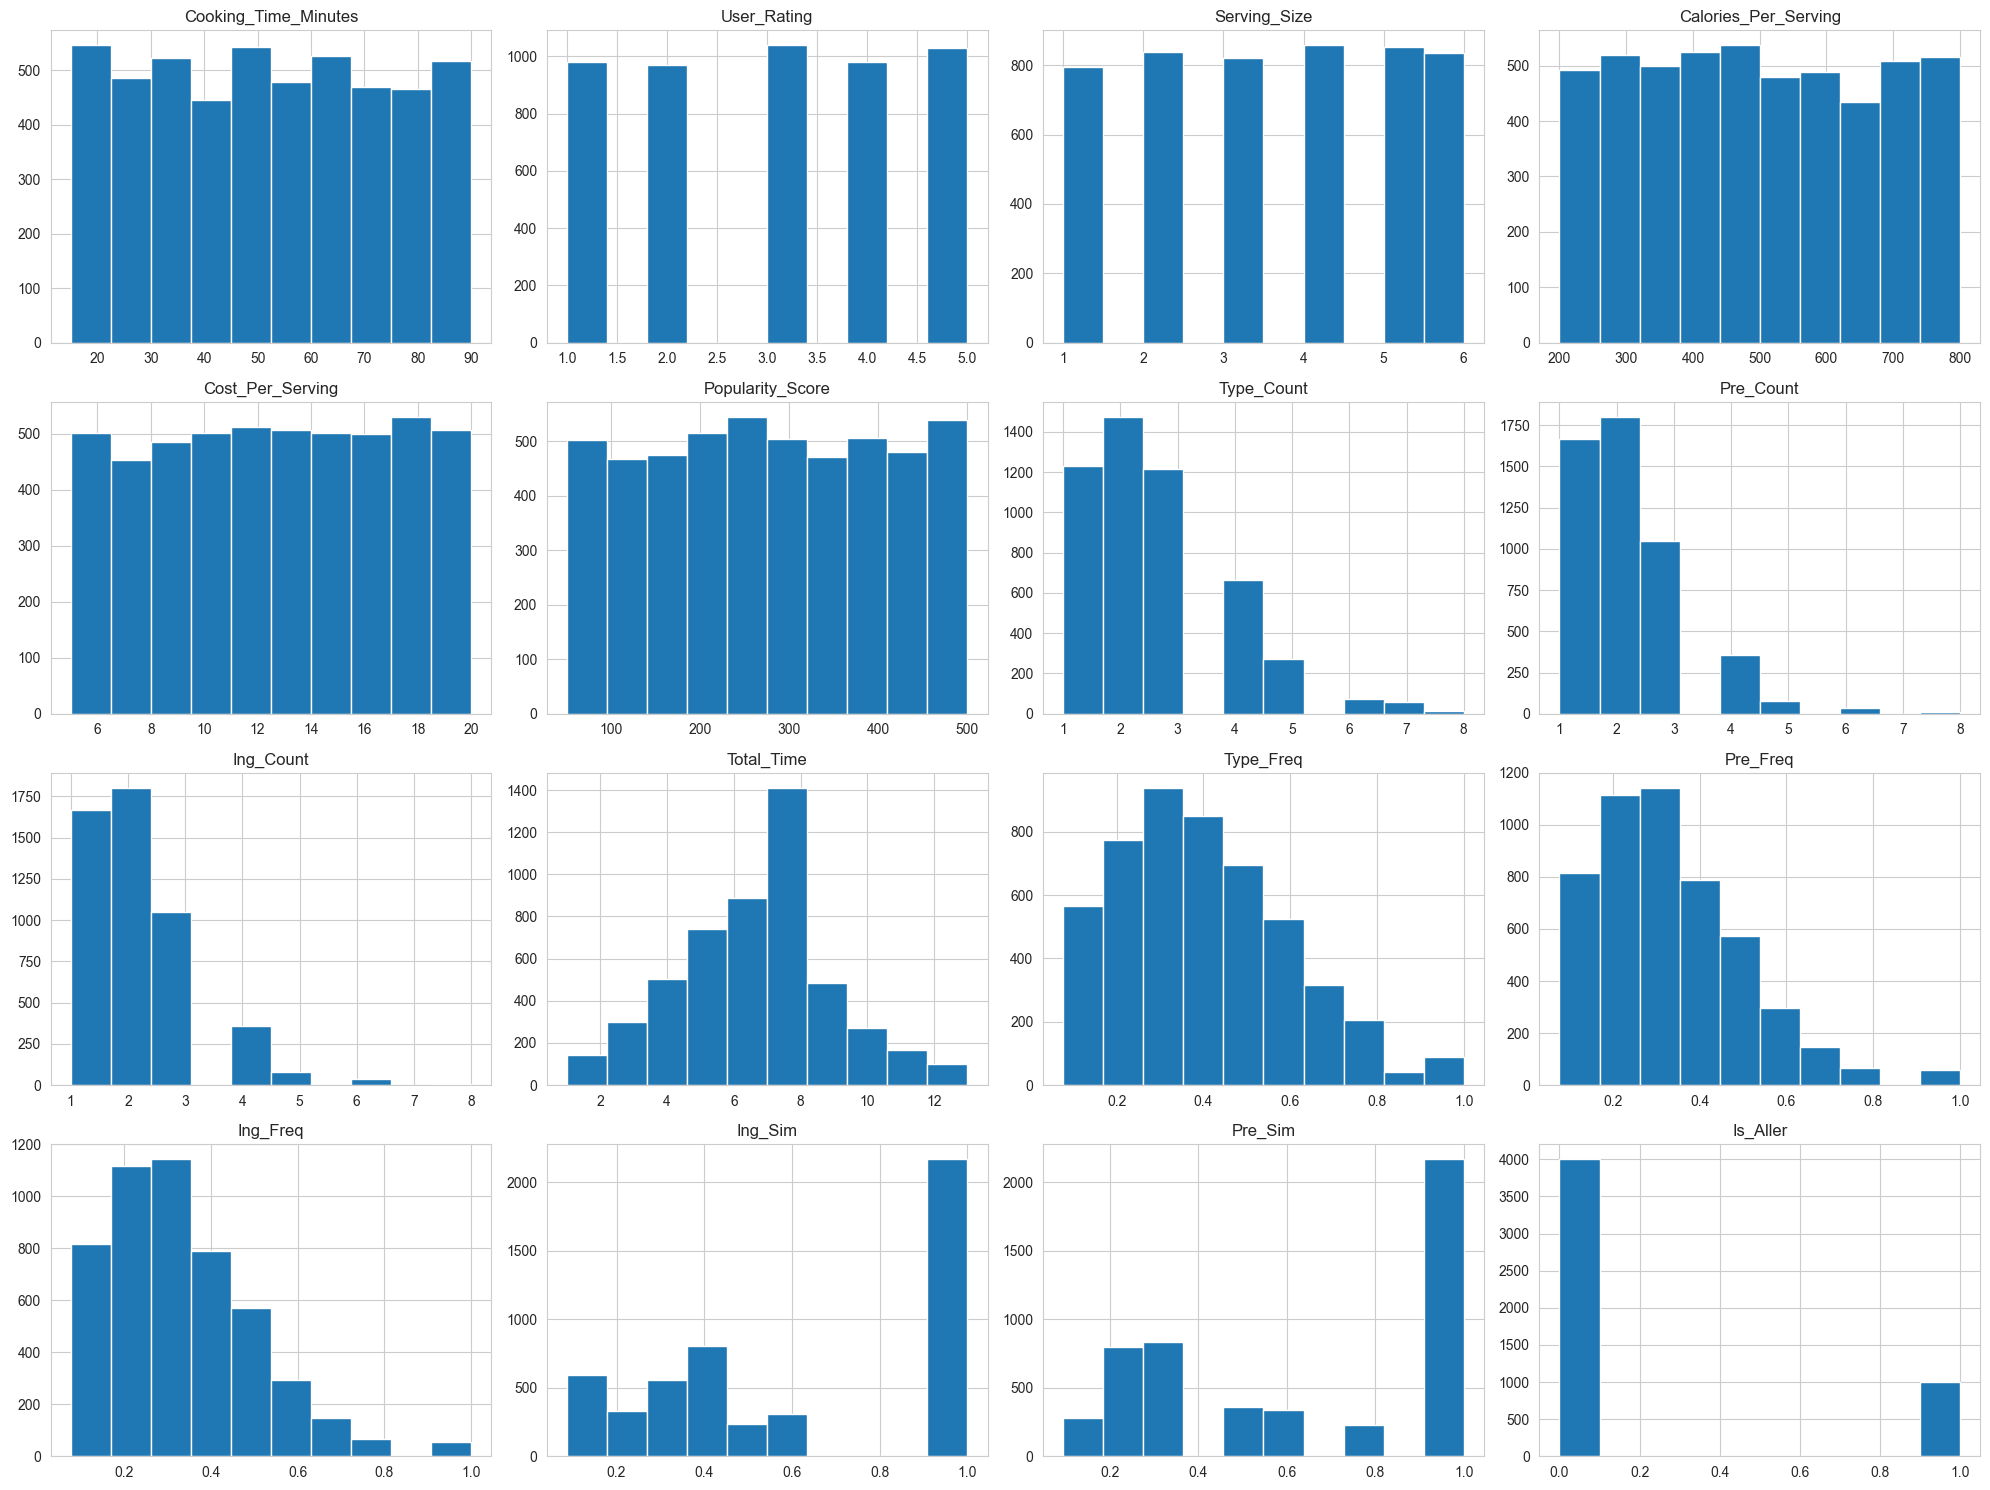

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

df = pd.read_csv('recipe_processed.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.drop_duplicates(inplace=True)

print(f"Original shape: {df.shape}")
print(f"Shape after dropna: {df.dropna().shape}")

print('-' * 80)
print(df.isna().sum())

print('-' * 80)
print(df.describe())


df.hist(figsize=(20, 15))
plt.tight_layout()
plt.show()


## 2. Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Handle missing values
# df['User_Preferences'] = df['User_Preferences'].fillna('None')

# Feature selection
features = ['Recipe_ID', 'Cooking_Time_Minutes','Difficulty_Level', 'Cuisine_Type',
            'Calories_Per_Serving', 'Cost_Per_Serving','Popularity_Score',
            'Season', 'Occasion', 'Serving_Size',
            'Is_Aller', 'Pre_Sim', 'Ing_Sim', 'Type_Freq', 'Pre_Freq', 'Ing_Freq',
            'Type_Count', 'Pre_Count', 'Ing_Count', 'User_Rating'] # 'User_Preferences',
df = df[features].copy()


# Standardize numerical features
numeric_features = ['Cooking_Time_Minutes', 'Calories_Per_Serving', 'Cost_Per_Serving',
                    'Popularity_Score', 'Serving_Size', 'Pre_Sim', 'Ing_Sim',
                    'Type_Freq', 'Pre_Freq', 'Ing_Freq', 'Type_Count', 'Pre_Count', 'Ing_Count']
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[numeric_features])
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_features, index=df.index)

# Encode categorical features
categorical_features = ['Difficulty_Level', 'Cuisine_Type', 'Season', 'Occasion']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(df[categorical_features])
categorical_encoded_df = pd.DataFrame(categorical_encoded,
                                      columns=encoder.get_feature_names_out(categorical_features),
                                      index=df.index)

X = pd.concat([numeric_scaled_df, categorical_encoded_df], axis=1)
y = df['User_Rating']

X.head()

,Cooking_Time_Minutes,Calories_Per_Serving,Cost_Per_Serving,Popularity_Score,Serving_Size,Pre_Sim,Ing_Sim,Type_Freq,Pre_Freq,Ing_Freq,...,Cuisine_Type_Italian,Cuisine_Type_Mexican,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Occasion_Casual,Occasion_Dinner,Occasion_Lunch,Occasion_Party
0,0.137114,0.064842,0.352643,0.970622,0.278364,1.041029,1.074497,0.469792,0.952974,0.952974,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.592069,-1.284414,0.803549,-0.717496,0.278364,1.041029,1.074497,1.769318,0.952974,0.952974,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.728790,-1.180625,-0.144510,-1.072078,0.867369,-0.957243,-0.761494,-0.974126,-0.725383,-0.725383,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.318625,0.474231,-0.516796,-0.231873,1.456374,-1.182337,-1.546677,-0.396559,-0.054040,-0.054040,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.504330,0.825960,0.019666,0.847289,0.278364,1.041029,1.074497,-0.179971,0.197713,0.197713,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 3. Outlier Detection

Best number of components (AIC): 12
Best number of components (BIC): 12


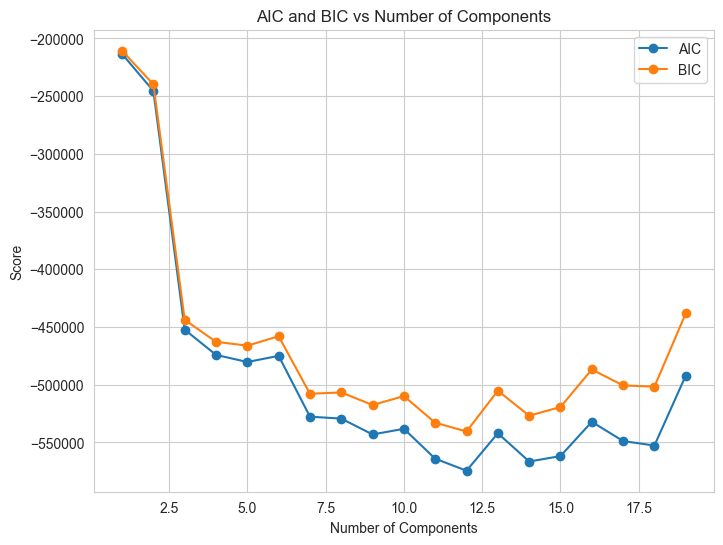

In [3]:
from sklearn.mixture import GaussianMixture

# Use AIC and BIC to select the number of GMM components
n_components_range = range(1, 20)
aic_scores = []
bic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    aic_scores.append(gmm.aic(X))
    bic_scores.append(gmm.bic(X))

# Find the minimum AIC and BIC values
best_n_aic = n_components_range[np.argmin(aic_scores)]
best_n_bic = n_components_range[np.argmin(bic_scores)]
print(f"Best number of components (AIC): {best_n_aic}")
print(f"Best number of components (BIC): {best_n_bic}")

# Visualize AIC and BIC
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC and BIC vs Number of Components')
plt.legend()
plt.show()


In [4]:
gmm = GaussianMixture(n_components=best_n_bic, random_state=42)
gmm.fit(X)

# Calculate the log-likelihood score for each sample
log_likelihood = gmm.score_samples(X)

# Set the outlier threshold
threshold = np.percentile(log_likelihood, 5)
outliers = log_likelihood < threshold
print(f"Number of detected outliers: {outliers.sum()}")

# Remove outliers
X_clean = X.loc[~outliers]
y_clean = y.loc[~outliers]
print(f"Data size after removing outliers: {X_clean.shape[0]}")

# Split the cleaned data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

Number of detected outliers: 250
Data size after removing outliers: 4750


## 4. Model Selection and Evaluation


Linear Regression (Train) Evaluation Results:
Mean Squared Error (MSE): 1.9750
Root Mean Squared Error (RMSE): 1.4054
Mean Absolute Error (MAE): 1.1962
R² Score: 0.0033

Linear Regression (Test) Evaluation Results:
Mean Squared Error (MSE): 2.0763
Root Mean Squared Error (RMSE): 1.4409
Mean Absolute Error (MAE): 1.2414
R² Score: -0.0153

Best Random Forest Parameters: {'max_depth': 10, 'n_estimators': 200}
Random Forest (Train) Evaluation Results:
Mean Squared Error (MSE): 1.3380
Root Mean Squared Error (RMSE): 1.1567
Mean Absolute Error (MAE): 0.9824
R² Score: 0.3248

Random Forest (Test) Evaluation Results:
Mean Squared Error (MSE): 2.0577
Root Mean Squared Error (RMSE): 1.4345
Mean Absolute Error (MAE): 1.2407
R² Score: -0.0062

Features contributing to top 90.0% of importance:
                 Feature  Importance  Cumulative_Importance
2       Cost_Per_Serving    0.155913               0.155913
3       Popularity_Score    0.148276               0.304189
1   Calories_Per_Serving    

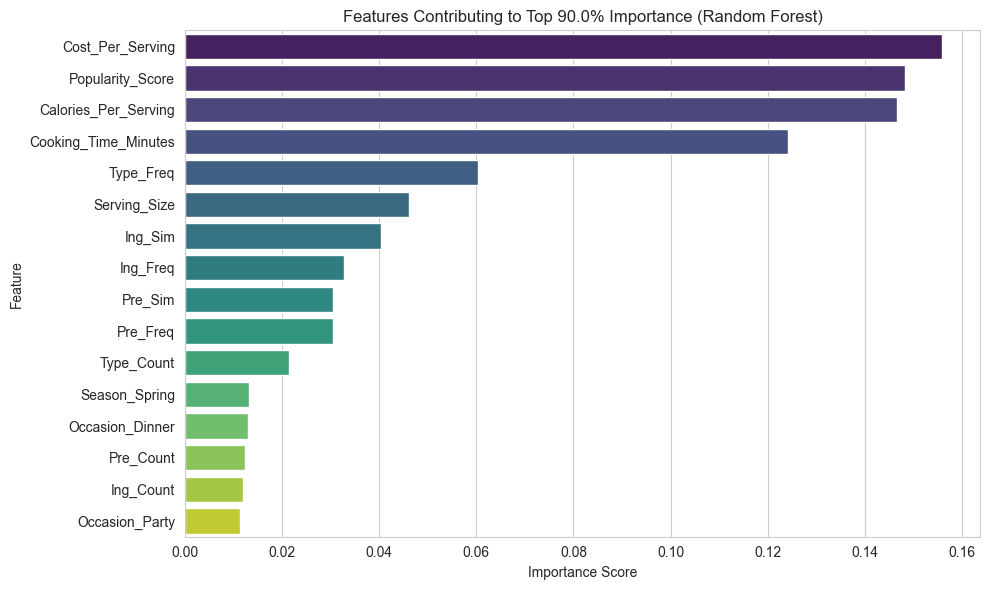

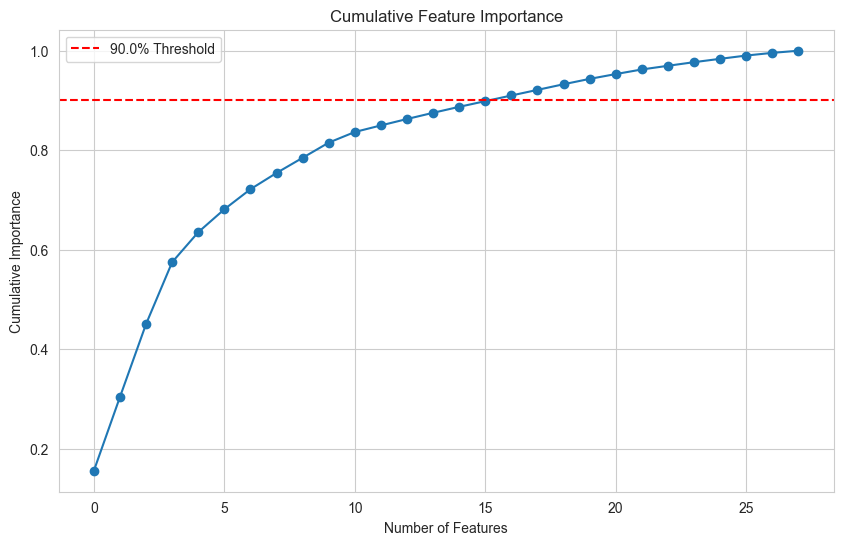

Best Neural Network Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.1, 'max_iter': 500}
Neural Network (Train) Evaluation Results:
Mean Squared Error (MSE): 1.9806
Root Mean Squared Error (RMSE): 1.4073
Mean Absolute Error (MAE): 1.1869
R² Score: 0.0005

Neural Network (Test) Evaluation Results:
Mean Squared Error (MSE): 2.0528
Root Mean Squared Error (RMSE): 1.4327
Mean Absolute Error (MAE): 1.2208
R² Score: -0.0038

Lasso Regression (Test) Evaluation Results:
Mean Squared Error (MSE): 2.0541
Root Mean Squared Error (RMSE): 1.4332
Mean Absolute Error (MAE): 1.2205
R² Score: -0.0045

Best Lasso Parameters: {'alpha': 0.1}
GBDT (Test) Evaluation Results:
Mean Squared Error (MSE): 2.0558
Root Mean Squared Error (RMSE): 1.4338
Mean Absolute Error (MAE): 1.2284
R² Score: -0.0053

Best GBDT Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGBoost (Test) Evaluation Results:
Mean Squared Error (MSE): 2.0551
Root Mean Squared E

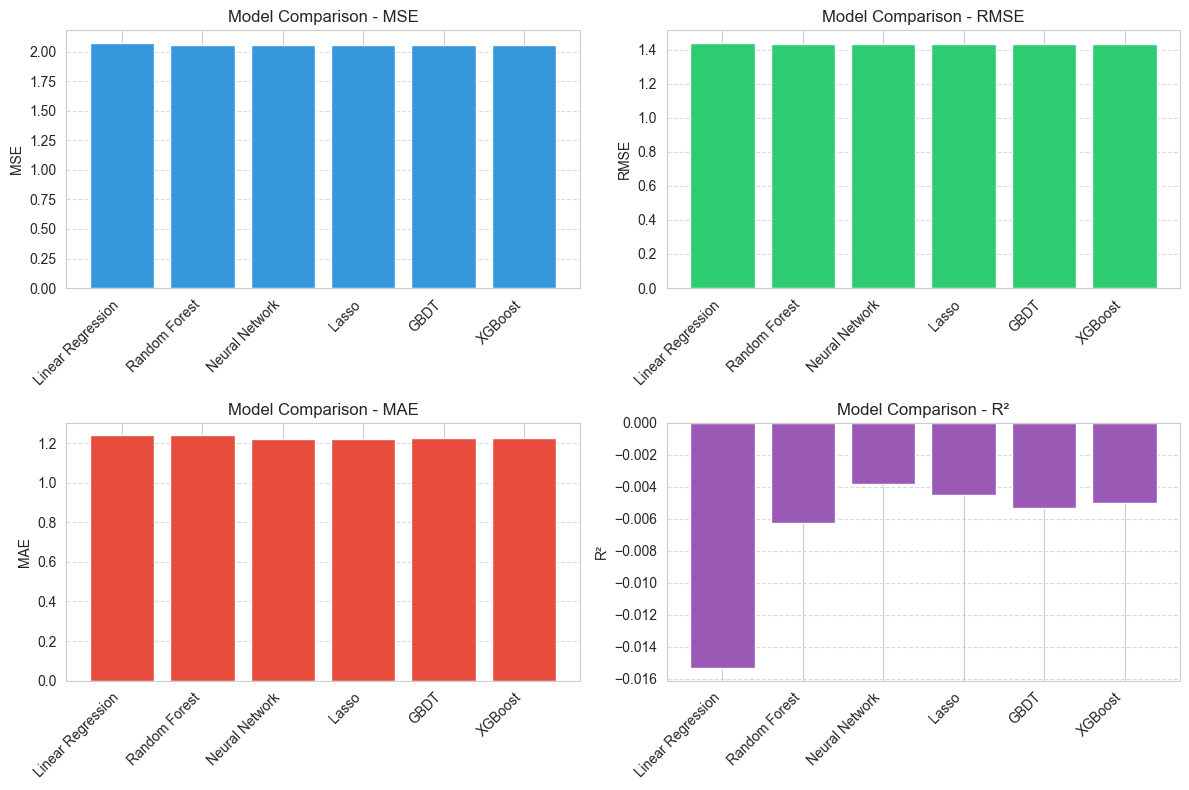

Best model based on RMSE: Neural Network


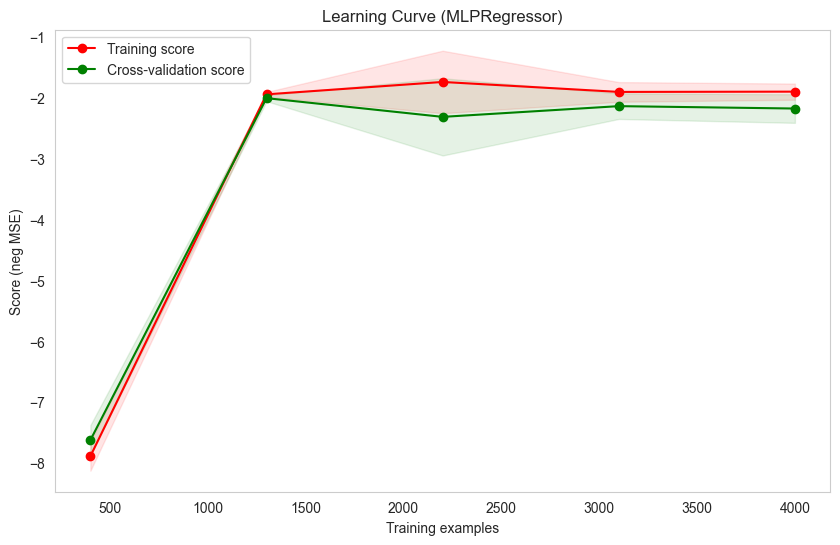

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

results = {}

# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Evaluation Results:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print()
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}


# Model training and tuning
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr_train = lr.predict(X_train)
y_pred_lr_test = lr.predict(X_test)
evaluate_model(y_train, y_pred_lr_train, "Linear Regression (Train)")
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr_test, "Linear Regression (Test)")

# 2. Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    # 'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_estimator_
y_pred_rf_train = best_rf.predict(X_train)
y_pred_rf_test = best_rf.predict(X_test)
evaluate_model(y_train, y_pred_rf_train, "Random Forest (Train)")
results['Random Forest'] = evaluate_model(y_test, y_pred_rf_test, "Random Forest (Test)")

importances = best_rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()

threshold = 0.9
selected_features = importance_df[importance_df['Cumulative_Importance'] <= threshold]

print(f"Features contributing to top {threshold*100}% of importance:")
print(selected_features)
print(f"Number of selected features: {len(selected_features)}")

plt.figure(figsize=(10, max(6, len(selected_features) * 0.3)))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=selected_features, palette='viridis', legend=False)
plt.title(f'Features Contributing to Top {threshold*100}% Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(len(importance_df)), importance_df['Cumulative_Importance'], marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}% Threshold')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.grid(True)
plt.show()

# 3. Neural Network
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu'],
    'learning_rate_init': [0.01, 0.1],
    'max_iter': [500, 1000]
}

mlp = MLPRegressor(random_state=42)
mlp_grid_search = GridSearchCV(mlp, mlp_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
mlp_grid_search.fit(X_train, y_train)
print(f"Best Neural Network Parameters: {mlp_grid_search.best_params_}")
best_mlp = mlp_grid_search.best_estimator_
y_pred_mlp_train = best_mlp.predict(X_train)
y_pred_mlp_test = best_mlp.predict(X_test)
evaluate_model(y_train, y_pred_mlp_train, "Neural Network (Train)")
results['Neural Network'] = evaluate_model(y_test, y_pred_mlp_test, "Neural Network (Test)")

# 4. Lasso
lasso_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}
lasso = Lasso(random_state=42)
lasso_grid_search = GridSearchCV(lasso, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
best_lasso = lasso_grid_search.best_estimator_
y_pred_lasso_test = best_lasso.predict(X_test)
results['Lasso'] = evaluate_model(y_test, y_pred_lasso_test, "Lasso Regression (Test)")
print(f"Best Lasso Parameters: {lasso_grid_search.best_params_}")

# 5. Gradient Boosting Decision Tree (GBDT)
gbdt_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gbdt = GradientBoostingRegressor(random_state=42)
gbdt_grid_search = GridSearchCV(gbdt, gbdt_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gbdt_grid_search.fit(X_train, y_train)
best_gbdt = gbdt_grid_search.best_estimator_
y_pred_gbdt_test = best_gbdt.predict(X_test)
results['GBDT'] = evaluate_model(y_test, y_pred_gbdt_test, "GBDT (Test)")
print(f"Best GBDT Parameters: {gbdt_grid_search.best_params_}")

# 6. XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
xgboost = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_grid_search = GridSearchCV(xgboost, xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
best_xgb = xgb_grid_search.best_estimator_
y_pred_xgb_test = best_xgb.predict(X_test)
results['XGBoost'] = evaluate_model(y_test, y_pred_xgb_test, "XGBoost (Test)")
print(f"Best XGBoost Parameters: {xgb_grid_search.best_params_}")


metrics_df = pd.DataFrame(results).T
metrics_df.index.name = 'Model'

# Visualize model comparison
plt.figure(figsize=(12, 8))

# Create bar plots for each metric
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    if metric == 'R²':
        # For R², higher is better
        plt.bar(metrics_df.index, metrics_df[metric], color=colors[i])
    else:
        # For error metrics, lower is better
        plt.bar(metrics_df.index, metrics_df[metric], color=colors[i])
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Learning curves for the best model (based on test RMSE)
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({estimator.__class__.__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score (neg MSE)")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes,
        scoring='neg_mean_squared_error')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Find the best model based on test RMSE
best_model_name = metrics_df['RMSE'].idxmin()
print(f"Best model based on RMSE: {best_model_name}")

# Plot learning curve for the best model
if best_model_name == 'Random Forest':
    plot_learning_curve(best_rf, X, y)
elif best_model_name == 'Neural Network':
    plot_learning_curve(best_mlp, X, y)
elif best_model_name == 'Lasso':
    plot_learning_curve(best_lasso, X, y)
elif best_model_name == 'GBDT':
    plot_learning_curve(best_gbdt, X, y)
elif best_model_name == 'XGBoost':
    plot_learning_curve(best_xgb, X, y)
elif best_model_name == 'Linear Regression':
    plot_learning_curve(lr, X, y)
plt.show()